# Import Libraries

In [6]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset

In [7]:
def data_set(dir_data):
    data=[]
    target=[]
    data_map = {
    'with_mask':1,
    'without_mask':0
    }
    skipped=0
    img_dims = (96,96,3)
    root=dir_data+'_annotations.csv'
    df1 = pd.read_csv(root)
    df1.dataframeName = '_annotations.csv'
    nRow, nCol = df1.shape
    for i in range(len(df1)):
        without_mask='without_mask'
        k=dir_data+df1['filename'][i]
        image=cv2.imread(k)
        xmin=int(df1['xmin'][i])
        ymin=int(df1['ymin'][i])
        xmax=int(df1['xmax'][i])
        ymax=int(df1['ymax'][i])
        image=image[ymin:ymax,  xmin:xmax]
        try:
                # resizing to (70 x 70)
                image = cv2.resize(image,(70,70))
        except Exception as E:
                skipped += 1
                print(E)
                continue
        if(df1['class'][i]=='mask'):
            without_mask='with_mask'
        image=img_to_array(image)
        data.append(image)
        target.append(data_map[without_mask])
    data = np.array(data, dtype="float") / 255.0
    target = tf.keras.utils.to_categorical(np.array(target), num_classes=2)
    return data, target

OpenCV(3.4.1) C:\Miniconda3\conda-bld\opencv-suite_1533128839831\work\modules\imgproc\src\resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize

AxesImage(54,36;334.8x217.44)
shape= (70, 70, 3)


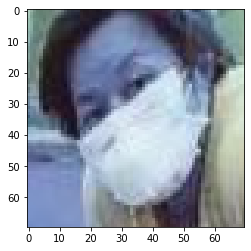

In [8]:
training_data, training_target=data_set('RawDataset/train/')
testing_data, testing_target=data_set('RawDataset/test/')
valid_data, valid_target=data_set('RawDataset/valid/')
print(plt.imshow(training_data[0]))
print('shape=',np.shape(training_data[1]))

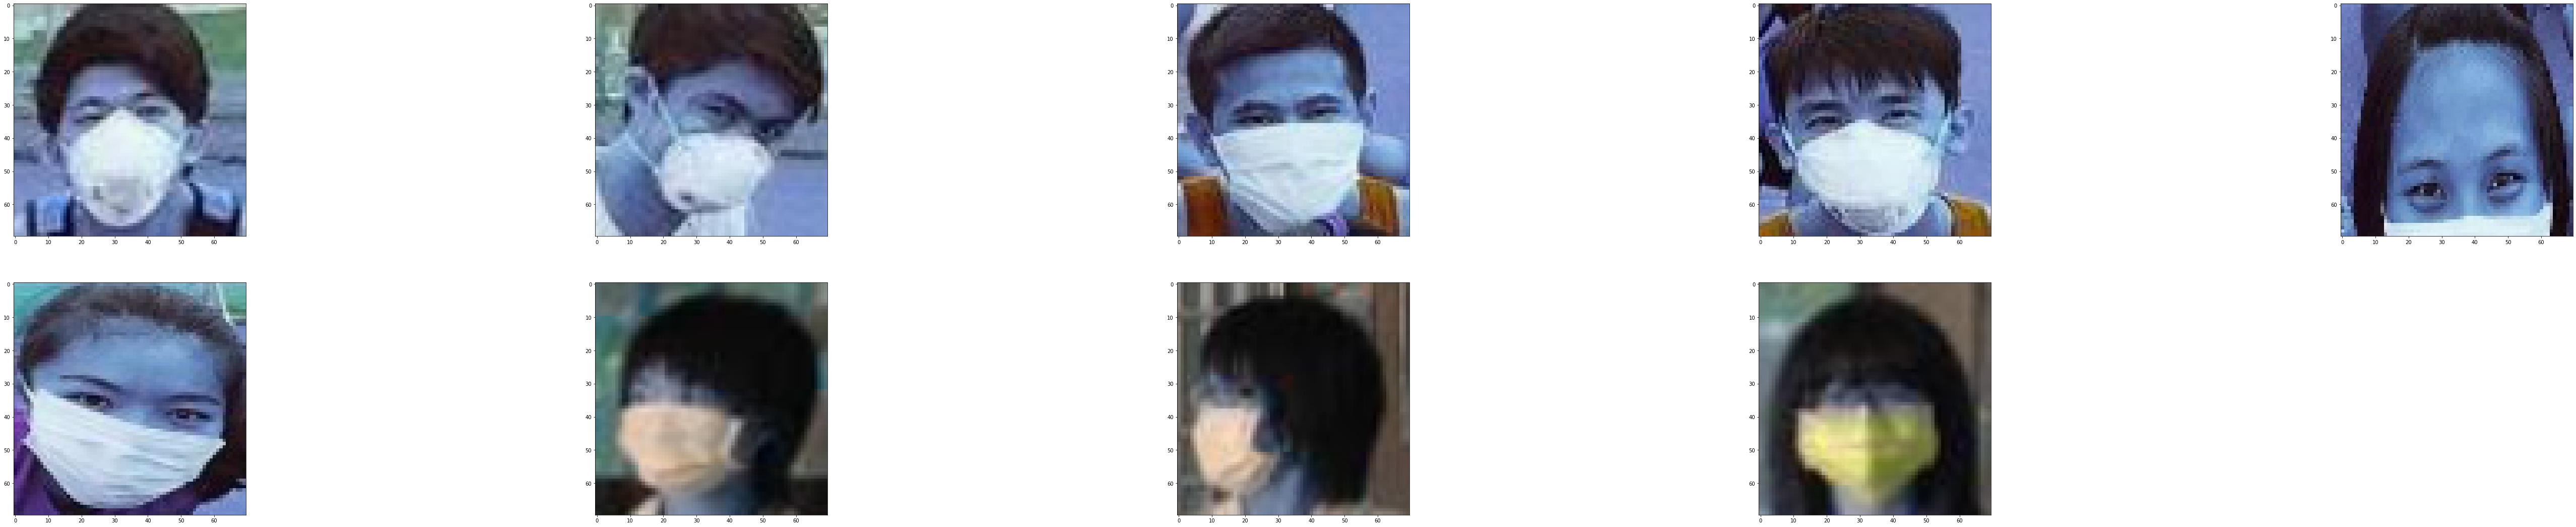

In [9]:
plt.figure(0, figsize=(100,100))
for i in range(1,10):
    plt.subplot(10,5,i)
    plt.imshow(training_data[i])

In [10]:
img_shape=training_data[0].shape
print(img_shape)
print(training_target.shape)
depth, height, width=3, img_shape[0], img_shape[1]
img_shape=(height, width, depth)
chanDim=-1
print(img_shape)
if backend.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        img_shape = (depth, height, width)
        chanDim = 1

(70, 70, 3)
(695, 2)
(70, 70, 3)


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [12]:
model=Sequential()

model.add(layers.Conv2D(32,(3,3),input_shape=img_shape))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,(3,3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(2,activation='softmax'))

adam =tf.keras.optimizers.Adam(0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 68, 68, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0

In [14]:
# augmenting dataset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [20]:
history = model.fit(aug.flow(training_data, training_target, batch_size=10),
                   epochs=50,
                   validation_data=(testing_data,testing_target),
                   verbose=2,
                   shuffle=True) 

  ...
    to  
  ['...']
Train for 70 steps, validate on 96 samples
Epoch 1/50
70/70 - 9s - loss: 0.2611 - accuracy: 0.8878 - val_loss: 0.1703 - val_accuracy: 0.9583
Epoch 2/50
70/70 - 9s - loss: 0.2368 - accuracy: 0.8993 - val_loss: 0.1948 - val_accuracy: 0.8958
Epoch 3/50
70/70 - 9s - loss: 0.2472 - accuracy: 0.9050 - val_loss: 0.1720 - val_accuracy: 0.9271
Epoch 4/50
70/70 - 10s - loss: 0.2197 - accuracy: 0.9108 - val_loss: 0.1186 - val_accuracy: 0.9375
Epoch 5/50
70/70 - 9s - loss: 0.2216 - accuracy: 0.9022 - val_loss: 0.1078 - val_accuracy: 0.9167
Epoch 6/50
70/70 - 9s - loss: 0.2518 - accuracy: 0.8734 - val_loss: 0.1111 - val_accuracy: 0.9271
Epoch 7/50
70/70 - 9s - loss: 0.2322 - accuracy: 0.9079 - val_loss: 0.1243 - val_accuracy: 0.9479
Epoch 8/50
70/70 - 9s - loss: 0.1944 - accuracy: 0.9338 - val_loss: 0.2437 - val_accuracy: 0.9062
Epoch 9/50
70/70 - 9s - loss: 0.2180 - accuracy: 0.9223 - val_loss: 0.1443 - val_accuracy: 0.9167
Epoch 10/50
70/70 - 10s - loss: 0.1872 - accuracy

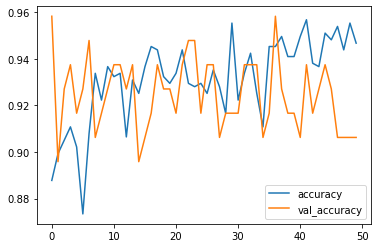

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])

In [22]:
testing_data.shape

(96, 70, 70, 3)

In [23]:
model.evaluate(valid_data, valid_target)

162/162 [==============================] - 0s 3ms/sample - loss: 0.1580 - accuracy: 0.9444


[0.1579846718814224, 0.9444444]

In [24]:
model.save('FaceMaskDetection_Using_cnn.h5')